# REFIT Dataset Preparation

In [ ]:
import pandas as pd
import time
import os
import re

DATASET_NAME = "refit"
DATA_DIRECTORY = '/media/vegaai/HardDrive/ProjectMSc/projectMSc-seq2point/data/refit/'
AGG_MEAN = 522
AGG_STD = 814
APPLIANCE_NAME = 'washingmachine'
SAVE_PATH = DATASET_NAME + '/' + APPLIANCE_NAME + '/'

params_appliance = {
    'kettle': {
        'windowlength': 599,
        'on_power_threshold': 2000,
        'max_on_power': 3998,
        'mean': 700,
        'std': 1000,
        's2s_length': 128,
        'houses': [2, 3, 4, 5, 6, 7, 8, 9, 12, 13, 19, 20],
        'channels': [8, 9, 9, 8, 7, 9, 9, 7, 6, 9, 5, 9],
        'test_house': 2,
        'validation_house': 5,
        'test_on_train_house': 5,
    },
    'microwave': {
        'windowlength': 599,
        'on_power_threshold': 200,
        'max_on_power': 3969,
        'mean': 500,
        'std': 800,
        's2s_length': 128,
        'houses': [4, 10, 12, 17, 19],
        'channels': [8, 8, 3, 7, 4],
        'test_house': 4,
        'validation_house': 17,
        'test_on_train_house': 10,
    },
    'fridge': {
        'windowlength': 599,
        'on_power_threshold': 50,
        'max_on_power': 3323,
        'mean': 200,
        'std': 400,
        's2s_length': 512,
        'houses': [2, 5, 9, 12, 15],
        'channels': [1, 1, 1,  1, 1],
        'test_house': 15,
        'validation_house': 12,
        'test_on_train_house': 5,
    },
    'dishwasher': {
        'windowlength': 599,
        'on_power_threshold': 10,
        'max_on_power': 3964,
        'mean': 700,
        'std': 1000,
        's2s_length': 1536,
        'houses': [5, 7, 9, 13, 16, 18, 20],
        'channels': [4, 6, 4, 4, 6, 6, 5],
        'test_house': 20,
        'validation_house': 18,
        'test_on_train_house': 13,
    },
    'washingmachine': {
        'windowlength': 599,
        'on_power_threshold': 20,
        'max_on_power': 3999,
        'mean': 400,
        'std': 700,
        's2s_length': 2000,
        'houses': [2, 5, 7, 8, 9, 15, 16, 17, 18],
        'channels': [2, 3, 5, 4, 3, 3, 5, 4, 5],
        'test_house': 8,
        'validation_house': 18,
        'test_on_train_house': 5,
    }
}


def load(path, building, appliance, channel):

    # load csv
    file_name = path + 'CLEAN_House' + str(building) + '.csv'
    single_csv = pd.read_csv(file_name,
                         header=0,
                         names=['aggregate', appliance],
                         usecols=[2, channel+2],
                         na_filter=False,
                         parse_dates=True,
                         memory_map=True)

    return single_csv


def main():
    start_time = time.time()        
    
    appliance_name = APPLIANCE_NAME
    print(appliance_name)
    
    path = DATA_DIRECTORY
    save_path = SAVE_PATH
    if not os.path.exists(save_path):
        os.makedirs(save_path)
    print(path)
    aggregate_mean = AGG_MEAN
    aggregate_std = AGG_STD  
    
    total_length = 0
    print("Starting creating dataset...")
    # Looking for proper files
    for idx, filename in enumerate(os.listdir(path)):
        single_step_time = time.time()
    
        if filename == 'CLEAN_House' + str(params_appliance[appliance_name]['test_house']) + '.csv':
            print('File: ' + filename + ' test set')
            # Loading
            test = load(path,
                 params_appliance[appliance_name]['test_house'],
                 appliance_name,
                 params_appliance[appliance_name]['channels'][params_appliance[appliance_name]['houses']
                        .index(params_appliance[appliance_name]['test_house'])]
                 )
    
            # Normalization
            test['aggregate'] = (test['aggregate'] - aggregate_mean) / aggregate_std
            test[appliance_name] = \
                (test[appliance_name] - params_appliance[appliance_name]['mean']) / params_appliance[appliance_name]['std']
    
            # Save
            test.to_csv(save_path + appliance_name + '_test_' + 'H' + str(params_appliance[appliance_name]['test_house'])
                        + '.csv', index=False)
    
            print("Size of test set is {:.3f} M rows (House {:d})."
                  .format(test.shape[0] / 10 ** 6, params_appliance[appliance_name]['test_house']))
            del test
    
        elif filename == 'CLEAN_House' + str(params_appliance[appliance_name]['validation_house']) + '.csv':
            print('File: ' + filename + ' validation set')
            # Loading
            val = load(path,
                 params_appliance[appliance_name]['validation_house'],
                 appliance_name,
                 params_appliance[appliance_name]['channels']
                 [params_appliance[appliance_name]['houses']
                        .index(params_appliance[appliance_name]['validation_house'])]
                 )
    
            # Normalization
            val['aggregate'] = (val['aggregate'] - aggregate_mean) / aggregate_std
            val[appliance_name] = \
                (val[appliance_name] - params_appliance[appliance_name]['mean']) / params_appliance[appliance_name]['std']
    
            # Save
            val.to_csv(save_path + appliance_name + '_validation_' + 'H' + str(params_appliance[appliance_name]['validation_house'])
                       + '.csv', index=False)
    
            print("Size of validation set is {:.3f} M rows (House {:d})."
                  .format(val.shape[0] / 10 ** 6, params_appliance[appliance_name]['validation_house']))
            del val
    
        elif int(re.search(r'\d+', filename).group()) in params_appliance[appliance_name]['houses']:
            print('File: ' + filename)
            print('    House: ' + re.search(r'\d+', filename).group())
    
            # Loading
            try:
                csv = load(path,
                           int(re.search(r'\d+', filename).group()),
                           appliance_name,
                           params_appliance[appliance_name]['channels']
                           [params_appliance[appliance_name]['houses']
                                  .index(int(re.search(r'\d+', filename).group()))]
                           )
    
                # Normalization
                csv['aggregate'] = (csv['aggregate'] - aggregate_mean) / aggregate_std
                csv[appliance_name] = \
                    (csv[appliance_name] - params_appliance[appliance_name]['mean']) / params_appliance[appliance_name][
                        'std']
    
                rows, columns = csv.shape
                total_length += rows
    
                if filename == 'CLEAN_House' + str(params_appliance[appliance_name]['test_on_train_house']) + '.csv':
                    csv.to_csv(save_path + appliance_name + '_test_on_train_' + 'H' + str(
                        params_appliance[appliance_name]['test_on_train_house'])
                               + '.csv', index=False)
                    print("Size of test on train set is {:.3f} M rows (House {:d})."
                          .format(csv.shape[0] / 10 ** 6, params_appliance[appliance_name]['test_on_train_house']))
    
                # saving the whole merged file
                csv.to_csv(save_path + appliance_name + '_training_.csv', mode='a', index=False, header=False)
    
                del csv
    
            except:
                pass
    
    print("Size of training set is {:.3f} M rows.".format(total_length / 10 ** 6))
    print("\nNormalization parameters: ")
    print("Mean and standard deviation values USED for AGGREGATE are:")
    print("    Mean = {:d}, STD = {:d}".format(aggregate_mean, aggregate_std))
    print('Mean and standard deviation values USED for ' + appliance_name + ' are:')
    print("    Mean = {:d}, STD = {:d}"
          .format(params_appliance[appliance_name]['mean'], params_appliance[appliance_name]['std']))
    print("\nTraining, validation and test sets are  in: " + save_path)
    print("Total elapsed time: {:.2f} min.".format((time.time() - start_time) / 60))
    
if __name__ == '__main__':
    main()


# NILM Sequence to Point Model Training with GPU on REFIT Dataset

2024-11-18 10:08:47.607573: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-11-18 10:08:48.145216: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
2024-11-18 10:08:49.078209: E tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:268] failed call to cuInit: CUDA_ERROR_UNKNOWN: unknown error
2024-11-18 10:08:49.078267: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:168] retrieving CUDA diagnostic information for host: vegaai-MS-7B86
2024-11-18 10:08:49.078281: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:175] hostname: vegaai-MS-7B86
2024-11-18 10:08:49.078440: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:199] libcuda reported versio

Loading dataset from:  refit/washingmachine/washingmachine_training_.csv
Epoch 1/10
31/31 [==============================] - 10s 294ms/step - loss: 0.0628 - mse: 0.0628 - msle: 0.0000e+00 - mae: 0.1890 - val_loss: 0.0089 - val_mse: 0.0089 - val_msle: 0.0000e+00 - val_mae: 0.0942
Epoch 2/10
31/31 [==============================] - 9s 293ms/step - loss: 0.0014 - mse: 0.0014 - msle: 0.0000e+00 - mae: 0.0310 - val_loss: 1.3924e-04 - val_mse: 1.3924e-04 - val_msle: 0.0000e+00 - val_mae: 0.0118
Epoch 3/10
31/31 [==============================] - 9s 293ms/step - loss: 5.5248e-05 - mse: 5.5248e-05 - msle: 0.0000e+00 - mae: 0.0061 - val_loss: 8.8910e-05 - val_mse: 8.8910e-05 - val_msle: 0.0000e+00 - val_mae: 0.0094
Epoch 4/10
31/31 [==============================] - 9s 294ms/step - loss: 3.8659e-06 - mse: 3.8659e-06 - msle: 0.0000e+00 - mae: 0.0016 - val_loss: 3.0274e-05 - val_mse: 3.0274e-05 - val_msle: 0.0000e+00 - val_mae: 0.0054
Epoch 5/10
31/31 [==============================] - 9s 295ms/s

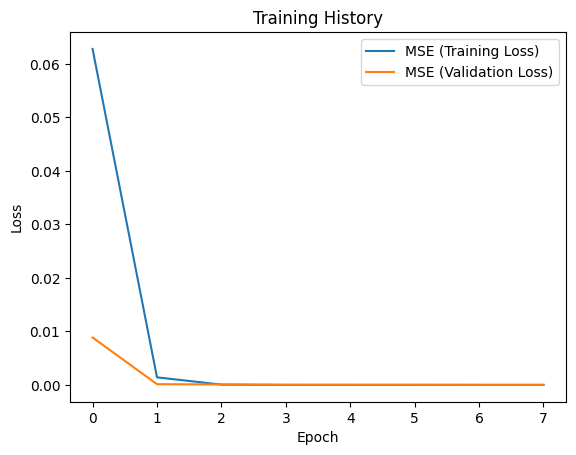

In [1]:
import tensorflow as tf
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '0'
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import gc
import tensorflow.keras.backend as K
import glob

# Parameters
appliance_name = "washingmachine" # kettle, dishwasher, fridge, microwave, washingmachine
dataset_name = "refit"
batch_size = 32
crop = 1000
network_type = "seq2point"
training_directory = dataset_name + "/" + appliance_name + "/" + appliance_name + "_training_.csv"
validation_directory = glob.glob(f"{dataset_name}/{appliance_name}/{appliance_name}_validation_H*.csv")[0]
save_model_dir = "saved_models/" + appliance_name + "_" + network_type + "_model.keras"
epochs = 10
input_window_length = 599
validation_frequency = 1
patience = 3
min_delta = 1e-6
verbose = 1
loss = "mse"
metrics = ["mse", "msle", "mae"]
learning_rate = 0.001
beta_1 = 0.9
beta_2 = 0.999
shuffle = True

window_size = 2 + input_window_length
window_offset = int((0.5 * window_size) - 1)
offset = window_offset
max_chunk_size = 5 * 10 ** 2
ram_threshold = 5 * 10 ** 5
skip_rows_train = 10000000
validation_steps = 100
skip_rows_val = 0

# Data Loader Function
class TrainSlidingWindowGenerator:
    def __init__(self, file_name, chunk_size, shuffle, offset, batch_size=1000, crop=100000, skip_rows=0, ram_threshold=5 * 10 ** 5):
        self.file_name = file_name
        self.batch_size = batch_size
        self.chunk_size = chunk_size
        self.shuffle = shuffle
        self.offset = offset
        self.crop = crop
        self.skip_rows = skip_rows
        self.ram_threshold = ram_threshold
        self.total_size = 0
        self.total_num_samples = crop

    def load_dataset(self):
        print("Loading dataset from: ", self.file_name)
        data_array = np.array(pd.read_csv(self.file_name, nrows=self.crop, skiprows=self.skip_rows, header=0))
        inputs = data_array[:, 0]
        outputs = data_array[:, 1]
        maximum_batch_size = inputs.size - 2 * self.offset
        self.total_num_samples = maximum_batch_size
        if self.batch_size < 0:
            self.batch_size = maximum_batch_size

        indicies = np.arange(maximum_batch_size)
        if self.shuffle:
            np.random.shuffle(indicies)

        while True:
            for start_index in range(0, maximum_batch_size, self.batch_size):
                splice = indicies[start_index : start_index + self.batch_size]
                input_data = np.array([inputs[index : index + 2 * self.offset + 1] for index in splice])
                output_data = outputs[splice + self.offset].reshape(-1, 1)
                yield input_data, output_data

# Model Creation Function
def create_model(input_window_length):
    input_layer = tf.keras.layers.Input(shape=(input_window_length,))
    reshape_layer = tf.keras.layers.Reshape((1, input_window_length, 1))(input_layer)
    conv_layer_1 = tf.keras.layers.Convolution2D(filters=30, kernel_size=(10, 1), strides=(1, 1), padding="same", activation="relu")(reshape_layer)
    conv_layer_2 = tf.keras.layers.Convolution2D(filters=30, kernel_size=(8, 1), strides=(1, 1), padding="same", activation="relu")(conv_layer_1)
    conv_layer_3 = tf.keras.layers.Convolution2D(filters=40, kernel_size=(6, 1), strides=(1, 1), padding="same", activation="relu")(conv_layer_2)
    conv_layer_4 = tf.keras.layers.Convolution2D(filters=50, kernel_size=(5, 1), strides=(1, 1), padding="same", activation="relu")(conv_layer_3)
    conv_layer_5 = tf.keras.layers.Convolution2D(filters=50, kernel_size=(5, 1), strides=(1, 1), padding="same", activation="relu")(conv_layer_4)
    flatten_layer = tf.keras.layers.Flatten()(conv_layer_5)
    label_layer = tf.keras.layers.Dense(1024, activation="relu")(flatten_layer)
    output_layer = tf.keras.layers.Dense(1, activation="linear")(label_layer)

    model = tf.keras.Model(inputs=input_layer, outputs=output_layer)
    return model

# Load Dataset for Training
training_chunker = TrainSlidingWindowGenerator(file_name=training_directory, 
                                               chunk_size=max_chunk_size,
                                               batch_size=batch_size,
                                               crop=crop,
                                               shuffle=shuffle,
                                               skip_rows=skip_rows_train,
                                               offset=offset,
                                               ram_threshold=ram_threshold)

# Load Dataset for Validation
validation_chunker = TrainSlidingWindowGenerator(file_name=validation_directory, 
                                                 chunk_size=max_chunk_size,
                                                 batch_size=batch_size,
                                                 crop=crop,
                                                 shuffle=False,
                                                 skip_rows=skip_rows_val,
                                                 offset=offset,
                                                 ram_threshold=ram_threshold)

# Create and Compile the Model
model = create_model(input_window_length)
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate, beta_1=beta_1, beta_2=beta_2), 
              loss=loss, 
              metrics=metrics)

# Set Early Stopping Callback
early_stopping = tf.keras.callbacks.EarlyStopping(monitor="loss", min_delta=min_delta, patience=patience, verbose=verbose, mode="auto")
callbacks = [early_stopping]

# Calculate Steps per Epoch
steps_per_training_epoch = np.round(int(training_chunker.total_num_samples / batch_size), decimals=0) if training_chunker.total_num_samples is not None else 1

# Train the Model
training_history = model.fit(training_chunker.load_dataset(),
                             validation_data=validation_chunker.load_dataset(),
                             steps_per_epoch=steps_per_training_epoch,
                             epochs=epochs,
                             verbose=verbose,
                             callbacks=callbacks,
                             validation_steps=validation_steps,
                             validation_freq=validation_frequency)

# Save the Model
if not os.path.exists(save_model_dir):
    open((save_model_dir), 'a').close()
model.save(save_model_dir)

# Plot Training Results
plt.plot(training_history.history["loss"], label="MSE (Training Loss)")
if "val_loss" in training_history.history:
    plt.plot(training_history.history["val_loss"], label="MSE (Validation Loss)")
plt.title('Training History')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.show()

del model
# del test_input, test_target, input_data, testing_history
gc.collect()
K.clear_session()


# NILM Sequence to Point Model Inference with GPU on REFIT Dataset

In [ ]:
import os
import logging
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import time
import glob

# Parameters
appliance_name = "washingmachine" # kettle, dishwasher, fridge, microwave, washingmachine
dataset_name = "refit"
batch_size = 1000
crop = 10000
network_type = "seq2point"
input_window_length = 599
test_directory = glob.glob(f"{dataset_name}/{appliance_name}/{appliance_name}_test_H*.csv")[0]
saved_model_dir = "saved_models/" + appliance_name + "_" + network_type + "_model.keras"
log_file_dir = "saved_models/" + appliance_name + "_" + network_type + ".log"

# Appliance data
appliance_data = {
    "kettle": {"mean": 700, "std": 1000},
    "fridge": {"mean": 200, "std": 400},
    "dishwasher": {"mean": 700, "std": 1000},
    "washingmachine": {"mean": 400, "std": 700},
    "microwave": {"mean": 500, "std": 800},
}

# Mains data
mains_data = {"mean": 522, "std": 814}

# Logging setup
logging.basicConfig(filename=log_file_dir, level=logging.INFO)

# Load the test dataset
data_frame = pd.read_csv(test_directory, nrows=crop, skiprows=0, header=0)
test_input = np.round(np.array(data_frame.iloc[:, 0], float), 6)
test_target = np.round(np.array(data_frame.iloc[:, 1], float), 6)
del data_frame

# Load the model
model = tf.keras.models.load_model(saved_model_dir)

# Create sliding windows for inference
window_size = input_window_length + 2
window_offset = int(0.5 * window_size - 1)
number_of_windows = 100
maximum_batch_size = test_input.size - 2 * window_offset
indicies = np.arange(maximum_batch_size)
input_data = np.array([test_input[index : index + 2 * window_offset + 1] for index in indicies[:number_of_windows]])

# Perform inference
start_time = time.time()
testing_history = model.predict(input_data, batch_size=batch_size, verbose=2)
end_time = time.time()
test_time = end_time - start_time

# Log inference time
inference_log = "Inference Time: " + str(test_time)
logging.info(inference_log)

# Denormalize the results
testing_history = ((testing_history * appliance_data[appliance_name]["std"]) + appliance_data[appliance_name]["mean"])
test_target = ((test_target * appliance_data[appliance_name]["std"]) + appliance_data[appliance_name]["mean"])
test_agg = (test_input.flatten() * mains_data["std"]) + mains_data["mean"]
test_agg = test_agg[:maximum_batch_size]

# Remove negative values
test_target[test_target < 0] = 0
testing_history[testing_history < 0] = 0
test_input[test_input < 0] = 0

# Plot results
plt.figure(1)
plt.plot(test_agg[window_offset: -window_offset], label="Aggregate")
plt.plot(test_target[:test_agg.size - (2 * window_offset)], label="Ground Truth")
plt.plot(testing_history[:maximum_batch_size], label="Predicted")
plt.title(appliance_name + " " + network_type)
plt.ylabel("Power Value (Watts)")
plt.xlabel("Testing Window")
plt.legend()
plt.show()


# NILM Sequence to Point Model Training with GPU on UKDALE Dataset

In [ ]:
import tensorflow as tf
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '0'
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os

# Parameters
appliance_name = "kettle"
dataset_name = "ukdale"
batch_size = 32
crop = 1000
network_type = "seq2point"
training_directory = "/media/vegaai/HardDrive/ProjectMSc/projectMSc-seq2point/dataset_management/" + dataset_name + "/" + appliance_name + "/" + appliance_name + "_training_.csv"
validation_directory = "/media/vegaai/HardDrive/ProjectMSc/projectMSc-seq2point/dataset_management/"+ dataset_name + "/" + appliance_name + "/" + appliance_name + "_validation_H5.csv"
save_model_dir = "saved_models/" + appliance_name + "_" + network_type + "_model.keras"
epochs = 10
input_window_length = 599
validation_frequency = 1
patience = 3
min_delta = 1e-6
verbose = 1
loss = "mse"
metrics = ["mse", "msle", "mae"]
learning_rate = 0.001
beta_1 = 0.9
beta_2 = 0.999
shuffle = True

window_size = 2 + input_window_length
window_offset = int((0.5 * window_size) - 1)
offset = window_offset
max_chunk_size = 5 * 10 ** 2
ram_threshold = 5 * 10 ** 5
skip_rows_train = 10000000
validation_steps = 100
skip_rows_val = 0

# Data Loader Function
class TrainSlidingWindowGenerator:
    def __init__(self, file_name, chunk_size, shuffle, offset, batch_size=1000, crop=100000, skip_rows=0, ram_threshold=5 * 10 ** 5):
        self.file_name = file_name
        self.batch_size = batch_size
        self.chunk_size = chunk_size
        self.shuffle = shuffle
        self.offset = offset
        self.crop = crop
        self.skip_rows = skip_rows
        self.ram_threshold = ram_threshold
        self.total_size = 0
        self.total_num_samples = crop

    def load_dataset(self):
        print("Loading dataset from: ", self.file_name)
        data_array = np.array(pd.read_csv(self.file_name, nrows=self.crop, skiprows=self.skip_rows, header=0))
        inputs = data_array[:, 0]
        outputs = data_array[:, 1]
        maximum_batch_size = inputs.size - 2 * self.offset
        self.total_num_samples = maximum_batch_size
        if self.batch_size < 0:
            self.batch_size = maximum_batch_size

        indicies = np.arange(maximum_batch_size)
        if self.shuffle:
            np.random.shuffle(indicies)

        while True:
            for start_index in range(0, maximum_batch_size, self.batch_size):
                splice = indicies[start_index : start_index + self.batch_size]
                input_data = np.array([inputs[index : index + 2 * self.offset + 1] for index in splice])
                output_data = outputs[splice + self.offset].reshape(-1, 1)
                yield input_data, output_data

# Model Creation Function
def create_model(input_window_length):
    input_layer = tf.keras.layers.Input(shape=(input_window_length,))
    reshape_layer = tf.keras.layers.Reshape((1, input_window_length, 1))(input_layer)
    conv_layer_1 = tf.keras.layers.Convolution2D(filters=30, kernel_size=(10, 1), strides=(1, 1), padding="same", activation="relu")(reshape_layer)
    conv_layer_2 = tf.keras.layers.Convolution2D(filters=30, kernel_size=(8, 1), strides=(1, 1), padding="same", activation="relu")(conv_layer_1)
    conv_layer_3 = tf.keras.layers.Convolution2D(filters=40, kernel_size=(6, 1), strides=(1, 1), padding="same", activation="relu")(conv_layer_2)
    conv_layer_4 = tf.keras.layers.Convolution2D(filters=50, kernel_size=(5, 1), strides=(1, 1), padding="same", activation="relu")(conv_layer_3)
    conv_layer_5 = tf.keras.layers.Convolution2D(filters=50, kernel_size=(5, 1), strides=(1, 1), padding="same", activation="relu")(conv_layer_4)
    flatten_layer = tf.keras.layers.Flatten()(conv_layer_5)
    label_layer = tf.keras.layers.Dense(1024, activation="relu")(flatten_layer)
    output_layer = tf.keras.layers.Dense(1, activation="linear")(label_layer)

    model = tf.keras.Model(inputs=input_layer, outputs=output_layer)
    return model

# Load Dataset for Training
training_chunker = TrainSlidingWindowGenerator(file_name=training_directory, 
                                               chunk_size=max_chunk_size,
                                               batch_size=batch_size,
                                               crop=crop,
                                               shuffle=shuffle,
                                               skip_rows=skip_rows_train,
                                               offset=offset,
                                               ram_threshold=ram_threshold)

# Load Dataset for Validation
validation_chunker = TrainSlidingWindowGenerator(file_name=validation_directory, 
                                                 chunk_size=max_chunk_size,
                                                 batch_size=batch_size,
                                                 crop=crop,
                                                 shuffle=False,
                                                 skip_rows=skip_rows_val,
                                                 offset=offset,
                                                 ram_threshold=ram_threshold)

# Create and Compile the Model
model = create_model(input_window_length)
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate, beta_1=beta_1, beta_2=beta_2), 
              loss=loss, 
              metrics=metrics)

# Set Early Stopping Callback
early_stopping = tf.keras.callbacks.EarlyStopping(monitor="loss", min_delta=min_delta, patience=patience, verbose=verbose, mode="auto")
callbacks = [early_stopping]

# Calculate Steps per Epoch
steps_per_training_epoch = np.round(int(training_chunker.total_num_samples / batch_size), decimals=0) if training_chunker.total_num_samples is not None else 1

# Train the Model
training_history = model.fit(training_chunker.load_dataset(),
                             validation_data=validation_chunker.load_dataset(),
                             steps_per_epoch=steps_per_training_epoch,
                             epochs=epochs,
                             verbose=verbose,
                             callbacks=callbacks,
                             validation_steps=validation_steps,
                             validation_freq=validation_frequency)

# Save the Model
if not os.path.exists(save_model_dir):
    open((save_model_dir), 'a').close()
model.save(save_model_dir)

# Plot Training Results
plt.plot(training_history.history["loss"], label="MSE (Training Loss)")
if "val_loss" in training_history.history:
    plt.plot(training_history.history["val_loss"], label="MSE (Validation Loss)")
plt.title('Training History')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.show()


# NILM Sequence to Point Model Inference with GPU on UKDALE Dataset